## Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Define a function that reads several calibration chessboard images and outputs the camera matrix and distortion coefficients.

import glob
images = glob.glob('./camera_cal/calibration*.jpg')

# arrays to store object points and image points from all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...,(7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

for idx in range(len(images)):
    img=mpimg.imread(images[idx])

    #convert image to grascale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are founad, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        #plt.show()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

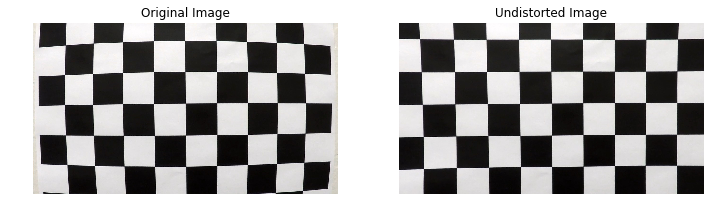

In [3]:
# Read one of the calibration images and show the undistortion result
img=mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('Undistorted Image')
plt.axis('off')
plt.show()

## Perspective Transform

To warp the images and get the birdeye view, we need to pick four source points and four destination points on the images. I picked four points on the left and right lane lines as the source points. In order to obtain the optimum four source points, I moved the two points which are farther from the camera and placed them at several locations along the lane lines (shown with different colors). The best performance was obtained for points shown with black color.   

Image Size:  (720, 1280, 3)


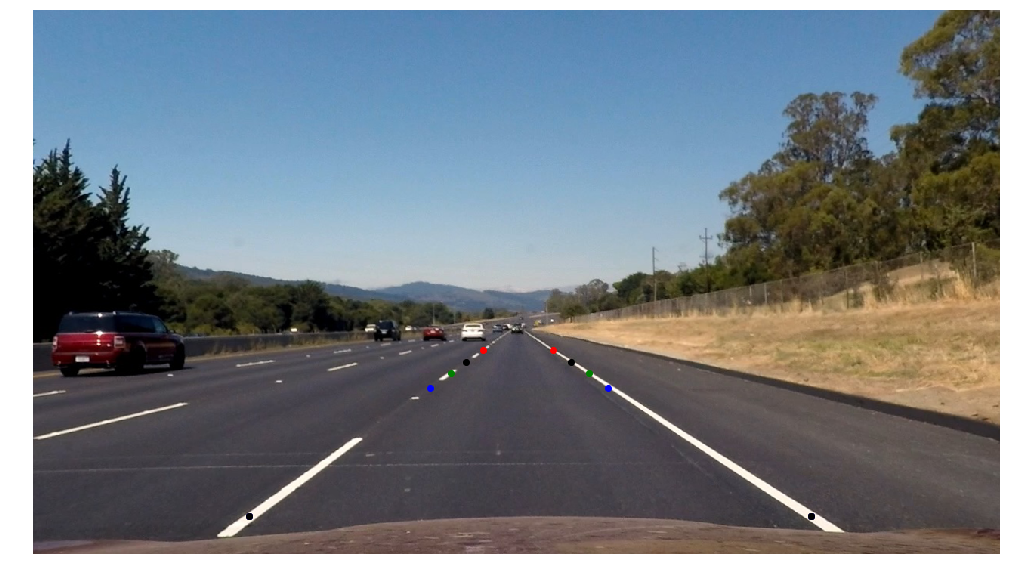

In [4]:
img_straight=mpimg.imread('./test_images/straight_lines2.jpg')
print('Image Size: ',img.shape)
undist_straight = cv2.undistort(img_straight, mtx, dist, None, mtx)

plt.figure(figsize=(20,10))
plt.imshow(undist_straight)
plt.scatter([595,688,285,1030],[450,450,670,670],color='r')
plt.scatter([553,735,285,1030],[480,480,670,670],color='g')
plt.scatter([525,760,285,1030],[500,500,670,670],color='b')
plt.scatter([572,712,285,1030],[465,465,670,670],color='k')
plt.axis('off')
plt.show()

In [28]:
# Define a function that takes an image, camera matrix and distortion coefficients
# and warps the image to get the birdeye view.

def warp_image(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size=(gray.shape[1],gray.shape[0])
    
    # For source points I'm using the four points on the two lane lines shown with black color in the image above.
    src = np.float32([[572,465],[712,465],[285,670],[1030,670]])

    # For destination points, I'm choosing four points on the corners of a rectangular
    # to be a nice fit for displaying our warped result.
    dst = np.float32([[170,0],[1030,0],[170,650],[1030,650]])
    #dst = np.float32([[90,0],[1180,0],[90,650],[1180,650]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

Transforming the previous image with the above function we will have have:

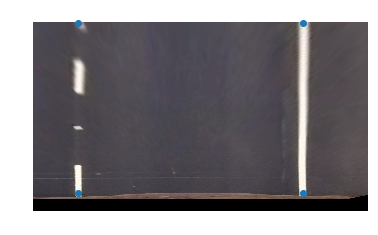

In [29]:
img_straight=mpimg.imread('./test_images/straight_lines2.jpg')
warped_straight, M, Minv = warp_image(img_straight, mtx, dist)

plt.imshow(warped_straight)
plt.scatter([170,1030,170,1030],[0,0,650,650])
plt.axis('off')
plt.show()

Now I can transform every image to get the birdeye view. The following code shows 8 test images along with their unwarped birdeye views. 

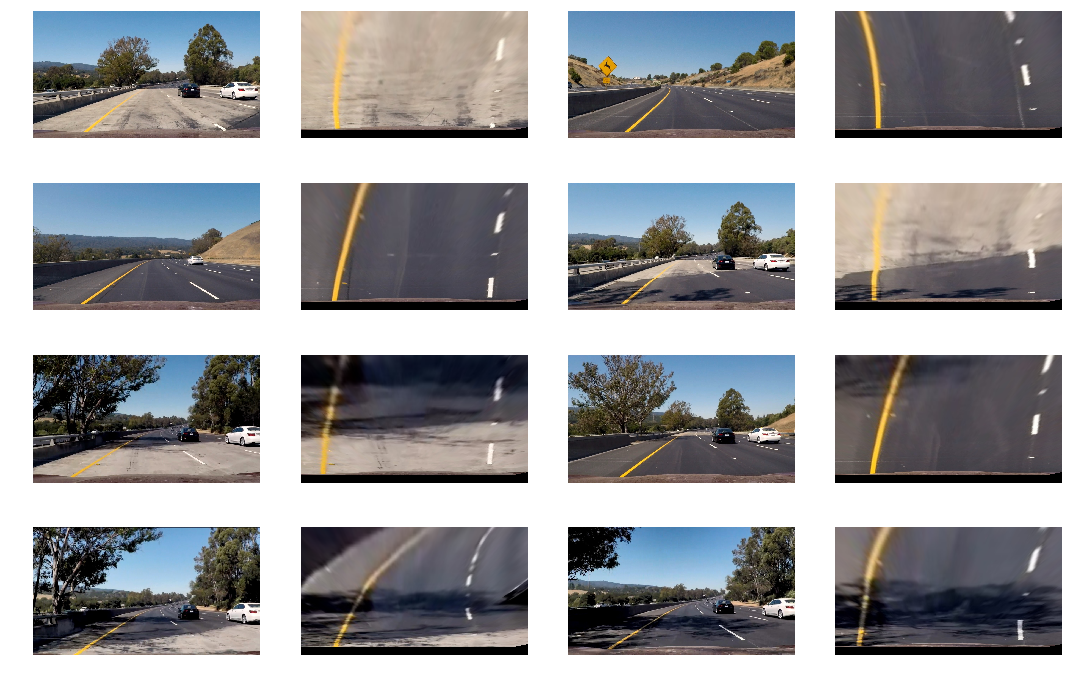

In [30]:
import matplotlib.pyplot as plt
import glob
test_images = glob.glob('./test_images/test*.jpg')

plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    imshape = img.shape
    warped, M , Minv= warp_image(img, mtx, dist)
    
    plt.subplot(4,4,2*(i+1)-1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(4,4,2*(i+1))
    plt.imshow(warped)
    plt.axis('off')
    plt.tight_layout()    
plt.show()


## Lane Lines Detection

Road images contain redundant objects such as trees and sky. In order to detect the lane lines properly, we need to remove these objects from the image first. One way to remove these objects is using masks. However, unwarping the images using perspective transform also takes care of this, as shown above. Here, I deicded to unwarp the images first and perform the lane detection after that, instead of using a mask.

### X Sobel Thresholding

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh = (20,150)):
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1

    # Return the result
    return binary_output

Since in the unwarped view, the lane lines tend to be vertical, I only use the 'x' orientation to detect the vertical edges.

In [ ]:
import matplotlib.pyplot as plt
import glob
test_images = glob.glob('./test_images/test*.jpg')

plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    warped, M , Minv= warp_image(img, mtx, dist)
    grad_binary = abs_sobel_thresh(warped, orient='x', thresh =(50,255))
    
    
    plt.subplot(4,4,2*(i+1)-1)
    plt.imshow(warped)
    plt.axis('off')
    plt.subplot(4,4,2*(i+1))
    plt.imshow(grad_binary, cmap='gray')
    plt.axis('off')
    plt.tight_layout()    
plt.show()

### HLS Channel Thresholding

The lane lines can also be detected based on their color space. Initially, I tried to convert the images to HLS format, and apply thresholds on each channel. The S channel showed to be more robust in detecting the lines; however, it still performed poorly in the presence shadows. Additionaly, finding the proper thresholds to be able to detect both shite and yellow lines was tricky.

Hence, I decided to focus on the color of each line and detect each color seperately. The following function, gets an image, breaks it into HLS channels, and applies three thresholds to isolate a specific color in the image. After detecting the left and white line separately, we will combine them to get both lane lines in the image. 

In [ ]:
# A function that converts the color space to HLS, separates the S, H, L channels, and applies separate thresholds on each channel.
# Note: img is the undistorted unwarped image
def hls_thresh(img, h_thresh, l_thresh, s_thresh):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # H Threshold color channel
    h_thresh_min = h_thresh[0]
    h_thresh_max = h_thresh[1]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > h_thresh_min) & (h_channel < h_thresh_max)] = 1
    
    # L Threshold color channel
    l_thresh_min = l_thresh[0]
    l_thresh_max = l_thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh_min) & (l_channel < l_thresh_max)] = 1
    
    
    # S Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel < s_thresh_max)] = 1
    
    # Combine the three binary thresholds and get the binary that satisfies all thresholds.
    hls_binary = np.zeros_like(s_binary)
    hls_binary[(h_binary == 1) & (l_binary == 1) & (s_binary == 1)] = 1

    return hls_binary

In [ ]:
# A function for performing hls color thresholding on test images and plotting the results
def hls_thresh_plot(h_thresh, l_thresh, s_thresh):

    import matplotlib.pyplot as plt
    import glob
    test_images = glob.glob('./test_images/test*.jpg')

    plt.figure(figsize=(15, 10))
    for i in range(len(test_images)):
        img=mpimg.imread(test_images[i])
        warped, M , Minv= warp_image(img, mtx, dist)
        warped_binary = hls_thresh(warped, h_thresh, l_thresh, s_thresh)

        plt.subplot(4,4,2*(i+1)-1)
        plt.imshow(warped)
        plt.axis('off')
        plt.subplot(4,4,2*(i+1))
        plt.imshow(warped_binary, cmap='gray')
        plt.axis('off')
        plt.tight_layout()    
    plt.show()

#### Detecting Yellow Lines

I applied the following thresholds on HLS channels to isolate and detect the lines with yellow color.

In [ ]:
hls_thresh_plot(h_thresh = (10,30), l_thresh = (50,255), s_thresh = (100,255) )

#### Detecting White Lines

Similarly, the following threshold values isolate the white color lines in the images.

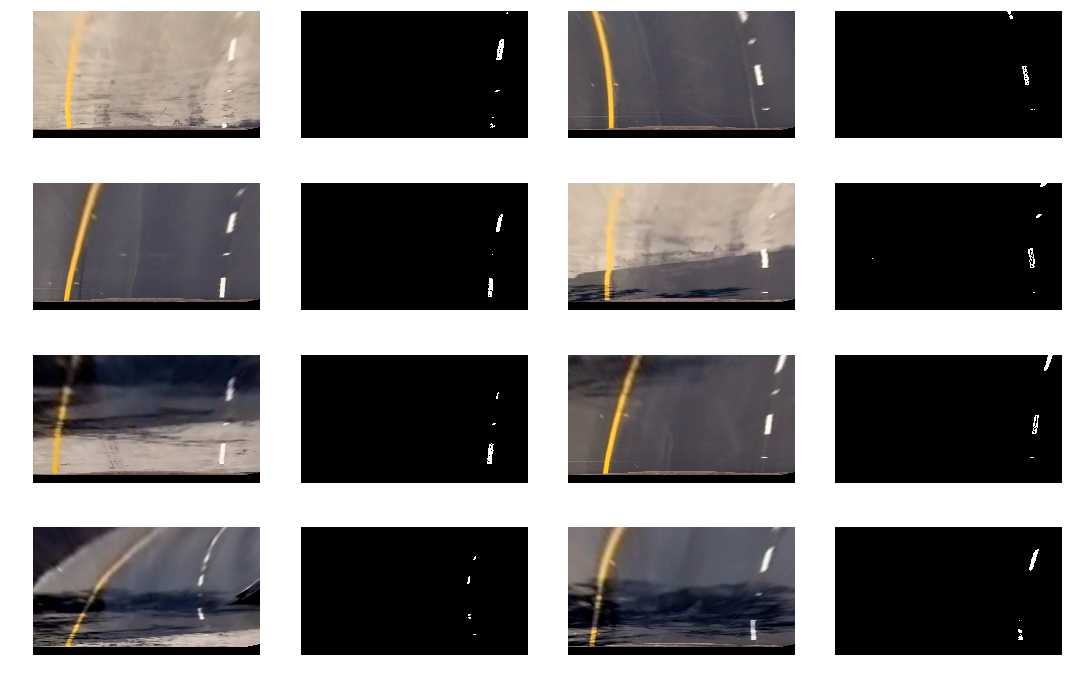

In [31]:
hls_thresh_plot(h_thresh = (0,255), l_thresh = (210,255), s_thresh = (0,255) )

#### Combination of Yellow and White Colors

With the threshold values obtained for detecting yellow and white lines, we can now combine them all to get both lane lines in a binary image.

In [ ]:
# A function that takes two hls threshold sets for white and yellow lines
# and combines them to get both left and right lines.
def combined_color_thresh(img, h_thresh1, l_thresh1, s_thresh1, h_thresh2, l_thresh2, s_thresh2):
    
    binary1 = hls_thresh(img, h_thresh1, l_thresh1, s_thresh1)
    binary2 = hls_thresh(img, h_thresh2, l_thresh2, s_thresh2)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 1
    
    return combined_binary

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    warped, M , Minv= warp_image(img, mtx, dist)
      
    binary1 = hls_thresh(warped, h_thresh = (10,30), l_thresh = (50,255), s_thresh = (100,255))
    binary2 = hls_thresh(warped,h_thresh = (0,255), l_thresh = (210,255), s_thresh = (0,255))
        
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 1

    plt.subplot(4,4,2*(i+1)-1)
    plt.imshow(warped)
    plt.axis('off')
    plt.subplot(4,4,2*(i+1))
    plt.imshow(combined_binary, cmap='gray')
    plt.axis('off')
    plt.tight_layout()    
plt.show() 

As can be seen, we are able to detect both left and right lines very well using this approach even in the presence of shadows or road texture and color changes.

### Combined X Gradient and Color Channel Threshold

I would like to see how the combination of X gradient and HLS color thresholding works. So I defined the following function that takes the threshold values for X gradient, and two HLS colors (for yellow and white lines) and outputs the combined binary.

In [ ]:
def grad_color_thresh(img, x_thresh = (50,100), h_thresh1 = (10,30), l_thresh1 = (50,255), s_thresh1 = (100,255), h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255)):

    # Sobel x
    orient= 'x'
    sobel_binary = abs_sobel_thresh(img, orient, x_thresh)

    # Threshold color channel
    hls_binary = combined_color_thresh(img, h_thresh1, l_thresh1, s_thresh1, h_thresh2, l_thresh2, s_thresh2)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    individual_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, hls_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(hls_binary == 1) | (sobel_binary == 1)] = 1

    return individual_binary, combined_binary# Plotting thresholded images

Using the threshold values obtained before, we will get the following results. In the images in the second column, the blue color represents pixels indentified with HLS color thresholding and the green color represents the pixels identifies using the X gradient thresholding. The images in the third column show the combination of both HLS and gradient threshoding. As can be seen, adding X gradient has not really improved the results. So, I decided to only use the HLS colors to detect the lines moving forward.

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    warped, M , Minv= warp_image(img, mtx, dist)
    individual_binary, combined_binary = grad_color_thresh(warped, x_thresh = (50,100), h_thresh1 = (10,30), l_thresh1 = (50,255),\
                                                      s_thresh1 = (100,255), h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255))

    
    plt.subplot(8,3,3*(i+1)-2)
    plt.imshow(warped)
    plt.axis('off')
    plt.subplot(8,3,3*(i+1)-1)
    plt.imshow(individual_binary, cmap='gray')
    plt.axis('off')
    plt.subplot(8,3,3*(i+1))
    plt.imshow(combined_binary, cmap='gray')
    plt.axis('off')
plt.tight_layout()    
plt.show()

## Finding the Lines

After applying calibration, perspective transform, and thresholding, to a road image, we should have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

The following function takes the undistorted, perspective transformed, thresholded image and identifies the left and right lines using a sliding window.

In [ ]:
def find_lines(binary_warped):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
    
    return out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds



# A function to calculate the radius of the line curvature
def get_radius(ploty, left_fitx, right_fitx):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    #print(left_curverad, 'm', right_curverad, 'm')
    

    
# A function to calculate the distance of the car center from the middle lane.
# Postive values indicate offset to the left and negativae values indicate offsets to the right.
def get_offset(img, left_fitx, right_fitx ):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lane_center = (right_fitx[-1]+left_fitx[-1])/2
    offset_pixels = lane_center-img.shape[1]/2
    offset_meters = offset_pixels * xm_per_pix

    return offset_meters    

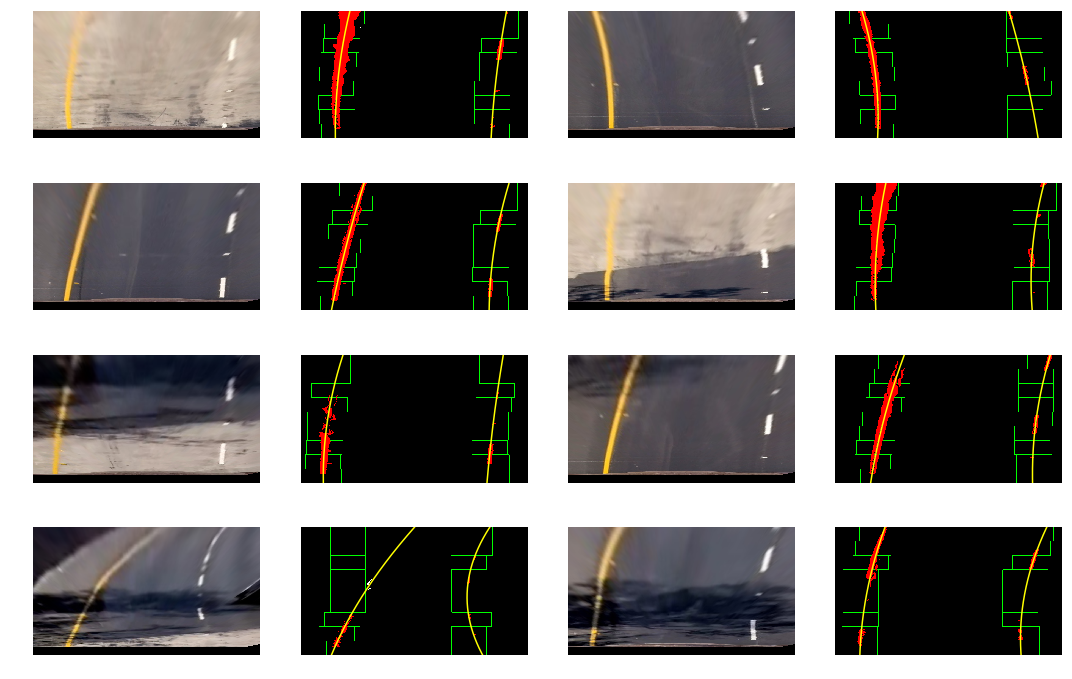

In [32]:
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    warped, M , Minv= warp_image(img, mtx, dist)
    #individual_binary, warped_binary = grad_color_thresh(warped, x_thresh = (50,100), h_thresh1 = (10,30), l_thresh1 = (50,255),\
    #                                                s_thresh1 = (100,255), h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255))
    
    warped_hls_binary = combined_color_thresh(warped, h_thresh1 = (10,30), l_thresh1 = (50,255), s_thresh1 = (100,255),\
                                              h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255))
    
    out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = find_lines(warped_hls_binary)

    
    plt.subplot(4,4,2*(i+1)-1)
    plt.imshow(warped)
    plt.axis('off')
    plt.subplot(4,4,2*(i+1))
    plt.imshow(out_img, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.axis('off')
    plt.tight_layout()    
plt.show()

## Transform the Detected Lanes Back to the Original View

No that we have detected the line we can transform the images to the original view.

In [37]:
def warp_back(warped, undist, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(unwarped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the unwarped blank image
    cv2.fillPoly(warped, np.int_([pts]), (0,255, 0))

    # transform the warped image to original image space using inverse perspective matrix (Minv)
    original_view = cv2.warpPerspective(warped, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, original_view, 0.3, 0)
    
    return result

In [38]:
# A function that takes a road image, transforms it to the bird view, detects the lane lines, and transforms it back to the original view.
# I use this function to process each image frame in the video.
def process_image(img):
    
    # Transform the image to the bird-eye view
    warped, M , Minv= warp_image(img, mtx, dist)
    
    #Detect the lane lines using gradient and color thresholding
    individual_binary, combined_binary = grad_color_thresh(warped, x_thresh = (50,100), h_thresh1 = (10,30), l_thresh1 = (50,255),\
                                                          s_thresh1 = (100,255), h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255))
    
    warped_hls_binary = combined_color_thresh(warped, h_thresh1 = (10,30), l_thresh1 = (50,255), s_thresh1 = (100,255),\
                                              h_thresh2 = (0,255), l_thresh2 = (210,255), s_thresh2 = (0,255))
    

    # find the lines that fit the detected pixels
    out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = find_lines(combined_binary)
    
    # Undistort the original image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Transform the detected lines back to original view and overlay it to the original undistorted image
    processed_img= warp_back(warped, undist, ploty, left_fitx, right_fitx, Minv)
    
    # Calculate the radius of right and left lines
    left_curverad, right_curverad = get_radius(ploty, left_fitx, right_fitx)
    radius=np.minimum(right_curverad, left_curverad)
    
    # Calculate the offset from the centerline
    offset = get_offset(warped, left_fitx, right_fitx )
    
    # Write the minimum of two radiuses on the image
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(processed_img, 'Lane Radius = '+str(radius)+ ' m', (5, 50), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(processed_img, 'Offset = '+str(offset)+ ' m', (5, 80), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
    return processed_img


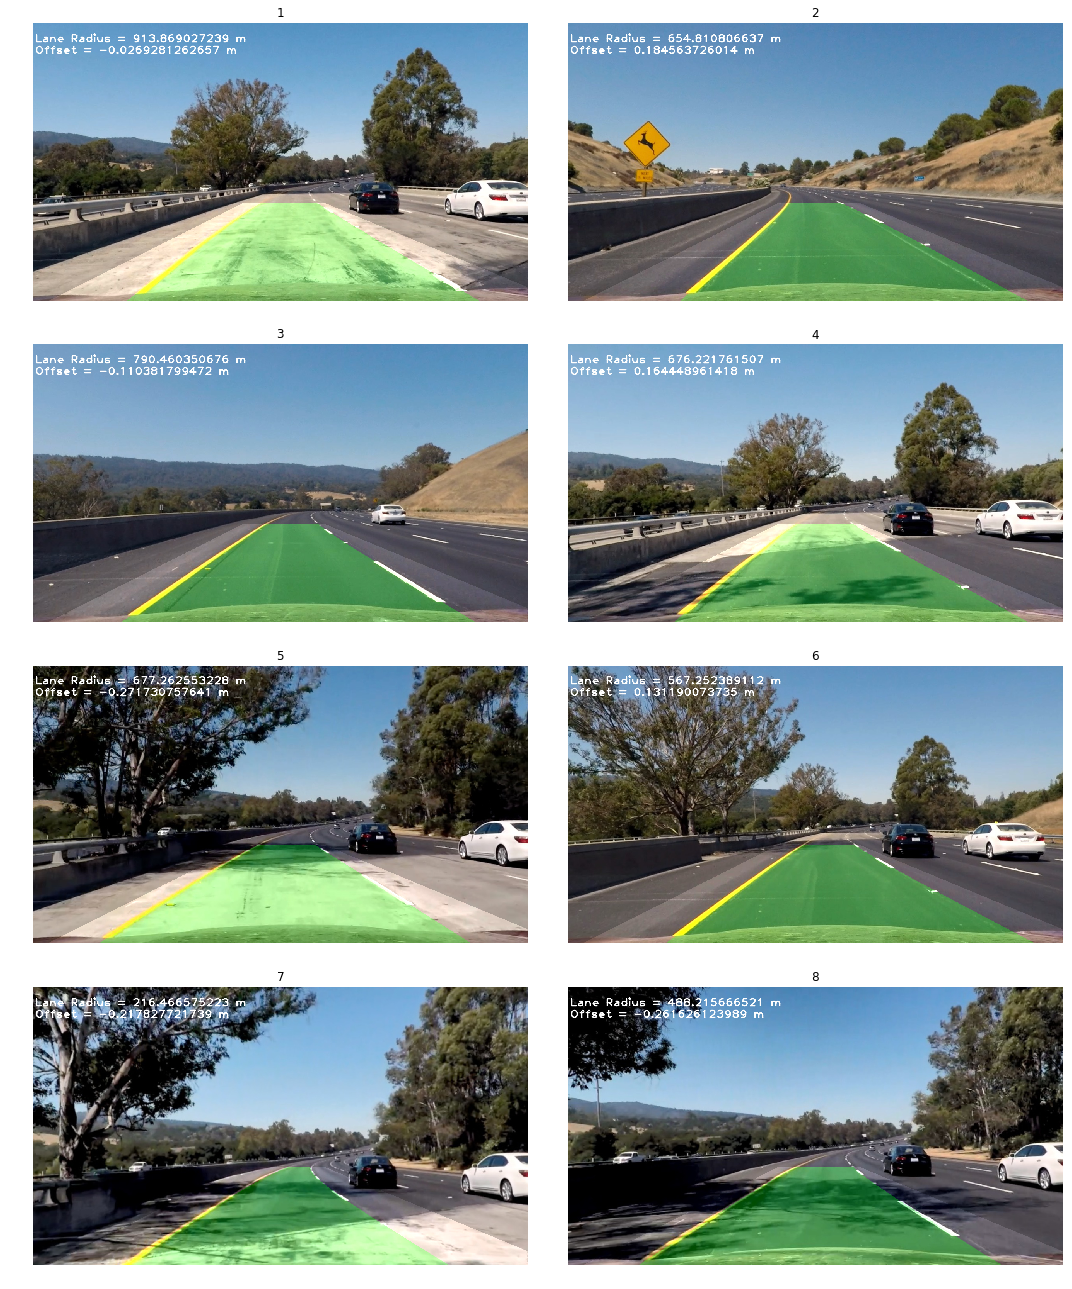

In [39]:
plt.figure(figsize=(15, 18))
for i in range(len(test_images)):
    img=mpimg.imread(test_images[i])
    warped_img = process_image(img)

    plt.subplot(4,2,i+1)
    plt.imshow(warped_img)
    plt.axis('off')
    plt.title(i+1)
    plt.tight_layout()    
plt.show()

## Create a Video

In [33]:
def create_video(video_name):
# Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip
    from IPython.display import HTML

    output_video = video_name+'_output.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
    clip = VideoFileClip(video_name+'.mp4')
    white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_video, audio=False)

In [ ]:
create_video('project_video')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 83%|███████████████████████████████▍      | 1042/1261 [04:13<00:49,  4.43it/s]

In [ ]:
#create_video('challenge_video')

In [ ]:
#create_video('harder_challenge_video')